In [1]:
!git clone https://github.com/NamNgo-2810/Cartoonizer-Model.git

Cloning into 'White-box-Cartoonization'...
remote: Enumerating objects: 188, done.
remote: Total 188 (delta 0), reused 0 (delta 0), pack-reused 188
Receiving objects: 100% (188/188), 63.41 MiB | 37.17 MiB/s, done.
Resolving deltas: 100% (64/64), done.
     |████████████████████████████████| 358kB 4.2MB/s 


In [2]:
import sys
sys.path.append('./White-box-Cartoonization/test_code')

import os
import matplotlib.pyplot as plt
import cartoonize

from PIL import Image

In [3]:
!mkdir -p ./source
!wget https://raw.githubusercontent.com/NamNgo-2810/Cartoonizer-Model/master/white_box/images/Ly.png -O ./source/image.jpg

--2021-03-11 12:37:19--  https://raw.githubusercontent.com/NamNgo-2810/Cartoonizer-Model/master/white_box/images/Ly.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1258172 (1.2M) [image/png]
Saving to: ‘./source/image.jpg’

./source/image.jpg  100%[===================>]   1.20M  --.-KB/s    in 0.08s   

2021-03-11 12:37:20 (15.2 MB/s) - ‘./source/image.jpg’ saved [1258172/1258172]



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


INFO:tensorflow:Restoring parameters from ./White-box-Cartoonization/test_code/saved_models/model-33999


100%|██████████| 1/1 [00:04<00:00,  4.27s/it]


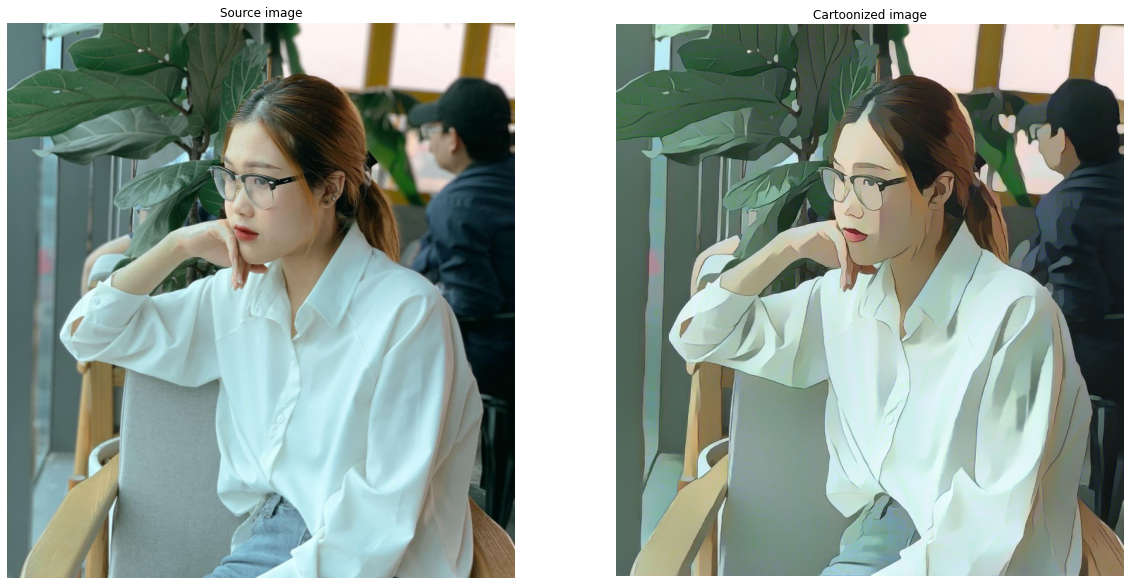

In [4]:
model_path = './White-box-Cartoonization/test_code/saved_models'
load_folder = './source'
save_folder = './cartoonized_images'
if not os.path.exists(save_folder): os.mkdir(save_folder)

cartoonize.cartoonize(load_folder, save_folder, model_path)
source_image = plt.imread('./source/image.jpg')
cartoonized_image = plt.imread('./cartoonized_images/image.jpg')

fig, ax = plt.subplots(1, 2, figsize=(20, 15))
ax[0].imshow(source_image)
ax[0].set_title('Source image')
ax[1].imshow(cartoonized_image)
ax[1].set_title('Cartoonized image')
[x.set_axis_off() for x in ax]
plt.show()

In [5]:
!mkdir -p models/CartoonGAN/saved_model

In [6]:
import network
import guided_filter

In [7]:
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

In [12]:
tf.reset_default_graph()

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.Session(config=config) as sess:
  input_photo = tf.placeholder(tf.float32, [1, None, None, 3], name='input_photo')

  network_out = network.unet_generator(input_photo)
  final_out = guided_filter.guided_filter(input_photo, network_out, r=1, eps=5e-3)

  all_vars = tf.trainable_variables()
  gene_vars = [var for var in all_vars if 'generator' in var.name]
  saver = tf.train.Saver(var_list=gene_vars)
  sess.run(tf.global_variables_initializer())
  saver.restore(sess, tf.train.latest_checkpoint(model_path))

  tf.saved_model.simple_save(sess, '/content/models/CartoonGAN/saved_model', inputs={input_photo.name: input_photo}, outputs={final_out.name: final_out})

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


INFO:tensorflow:Restoring parameters from ./White-box-Cartoonization/test_code/saved_models/model-33999
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: /content/models/CartoonGAN/saved_model/saved_model.pb


# **TensorFlow.js conversion**

In [9]:
!pip install tensorflowjs --quiet

     |████████████████████████████████| 71kB 3.0MB/s 
     |████████████████████████████████| 112kB 8.2MB/s 


In [13]:
!tensorflowjs_converter --input_format=tf_saved_model --output_node_names='final_output' \
    models/CartoonGAN/saved_model models/CartoonGAN/web

2021-03-11 12:49:06.697975: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-03-11 12:49:08.856458: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-03-11 12:49:08.857963: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-03-11 12:49:08.868640: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-03-11 12:49:08.868714: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (2a58e7bcdb03): /proc/driver/nvidia/version does not exist
2021-03-11 12:49:08.869302: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-03-11 12:49:08.990312: I tensorflow/compiler/mlir/mlir_graph_optimizati

In [14]:
!tensorflowjs_converter --quantize_float16 --input_format=tf_saved_model --output_node_names='final_output' models/CartoonGAN/saved_model/ models/CartoonGAN/web-float16

2021-03-11 12:51:19.552917: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-03-11 12:51:21.704259: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-03-11 12:51:21.705324: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-03-11 12:51:21.715951: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-03-11 12:51:21.716010: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (2a58e7bcdb03): /proc/driver/nvidia/version does not exist
2021-03-11 12:51:21.716593: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-03-11 12:51:21.812184: I tensorflow/compiler/mlir/mlir_graph_optimizati

In [15]:
!tensorflowjs_converter --quantize_uint8 --input_format=tf_saved_model --output_node_names='final_output' models/CartoonGAN/saved_model models/CartoonGAN/web-uint8

2021-03-11 12:53:25.093475: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-03-11 12:53:27.233926: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-03-11 12:53:27.235040: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-03-11 12:53:27.245723: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-03-11 12:53:27.245787: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (2a58e7bcdb03): /proc/driver/nvidia/version does not exist
2021-03-11 12:53:27.246413: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-03-11 12:53:27.342690: I tensorflow/compiler/mlir/mlir_graph_optimizati

In [16]:
!du -sh models/CartoonGAN/*

5.8M	models/CartoonGAN/saved_model
5.7M	models/CartoonGAN/web
2.9M	models/CartoonGAN/web-float16
1.5M	models/CartoonGAN/web-uint8


In [17]:
!zip -r models.zip models

  adding: models/ (stored 0%)
  adding: models/CartoonGAN/ (stored 0%)
  adding: models/CartoonGAN/web-float16/ (stored 0%)
  adding: models/CartoonGAN/web-float16/group1-shard1of1.bin (deflated 8%)
  adding: models/CartoonGAN/web-float16/model.json (deflated 93%)
  adding: models/CartoonGAN/saved_model/ (stored 0%)
  adding: models/CartoonGAN/saved_model/saved_model.pb (deflated 91%)
  adding: models/CartoonGAN/saved_model/variables/ (stored 0%)
  adding: models/CartoonGAN/saved_model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: models/CartoonGAN/saved_model/variables/variables.index (deflated 57%)
  adding: models/CartoonGAN/web/ (stored 0%)
  adding: models/CartoonGAN/web/group1-shard2of2.bin (deflated 7%)
  adding: models/CartoonGAN/web/model.json (deflated 93%)
  adding: models/CartoonGAN/web/group1-shard1of2.bin (deflated 7%)
  adding: models/CartoonGAN/web-uint8/ (stored 0%)
  adding: models/CartoonGAN/web-uint8/group1-shard1of1.bin (deflated 16%)
  adding: mo

In [18]:
from google.colab import files
files.download('models.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>